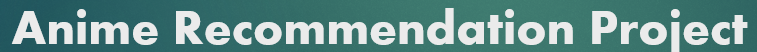

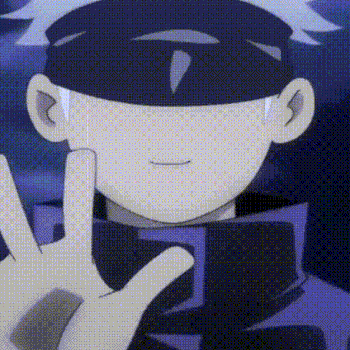

# Introduction To Data 📋

### This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.


### Anime.csv

1. anime_id - myanimelist.net's unique id identifying an anime.

2. name - full name of anime.

3. genre - comma separated list of genres for this anime.

4. type - movie, TV, OVA, etc.

5. episodes - how many episodes in this show. (1 if movie).

6. rating - average rating out of 10 for this anime.

7. members - number of community members that are in this anime's group.

### Rating.csv

1. user_id - non identifiable randomly generated user id.

2. anime_id - the anime that this user has rated.

3. rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).




# Importing Libraries 📗


In [2]:
import numpy as np 
import pandas as pd 
import scipy as sp


from sklearn.metrics.pairwise import cosine_similarity


# Data Processing And Data Analysis 🕵️

In [3]:
anime_path='../input/anime-recommendations-database/anime.csv'
ratings_path='../input/anime-recommendations-database/rating.csv'

In [4]:
anime_df=pd.read_csv(anime_path)
anime_df.head()

In [5]:
rating_df=pd.read_csv(ratings_path)
rating_df.head()

### Data Info

In [6]:
print("Anime Set(Row,Col)")
anime_df.shape


In [7]:
print("Rating Set(Row,Col)")
rating_df.shape

In [8]:
print("Anime Set Info")
anime_df.info()

In [9]:
print("Rating Set Info")
rating_df.info()

#### All the data types of each column in both data sets are consistent, so no need to format the data types.

## Processing Missing Data

In [10]:
print("Anime Set Missing Values")
anime_df.isnull().sum()

In [11]:
print("Rating Set Missing Values")
rating_df.isnull().sum()

#### Here there is no missing values in Rating Data, hence we need to handle Anime Data.

#### In this data sets, the data is reliable expect missing data. After fixing the missing values we can proceed to next step  

In [18]:
print(anime_df['type'].mode())
print(anime_df['genre'].mode())

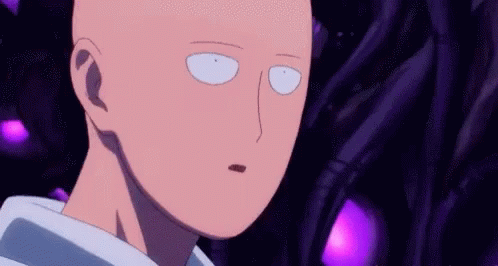

#### The Mode Value of genre is Hentai 🌝 and of type is TV 

In [19]:
#deleting anime with missing ratings
anime_df=anime_df[~np.isnan(anime_df['rating'])]

#filling Mode values for genre and type columns
anime_df['genre'] = anime_df['genre'].fillna(
anime_df['genre'].dropna().mode().values[0])

anime_df['type'] = anime_df['type'].fillna(
anime_df['type'].dropna().mode().values[0])

#checking if there are null values
anime_df.isnull().sum()

#### Filling NaN values
In this data ,the value -1 in ratings column indicates user didn't provide rating so we fill them with null values

In [20]:
rating_df['rating'].replace(-1,np.nan,inplace=True)
rating_df.head(25)

### Now We Will Develop Our Dataframe in Following Ways:

1. We need to recommend anime series only, so the relevant type is TV
2. We make a new Dataframe combining both anime and rating on the anime_id column.
3. Leaving only user_id, name and rating as the Df.
4. For computing purpose only we compute our Df based only on the first 7500 users.

In [21]:
# step 1
anime_df=anime_df[anime_df['type']=='TV']

#step 2
rated_anime = rating_df.merge(anime_df, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])

#step 3
rated_anime=rated_anime[['user_id', 'rating','name']]

#step 4
rated_anime_7500= rated_anime[rated_anime.user_id <= 7500]
rated_anime_7500.head()

### Pivot Table For Similarity
We will create a pivot table of users as rows and tv show names as columns. The pivot table will help us will be analized for the calcuations of similarity.

In [22]:
pivot = rated_anime_7500.pivot_table(index=['user_id'], columns=['name'], values='rating')
pivot.head()

### Now We Will Develop Our Pivot Table in following ways:
1. Normalization
2. Replacing NaN values with 0
3. Transposing the pivot for the next step.
4. Dropping columns with the values of 0 (unrated).
5. Using scipy package to convert to sparse matrix format for the similarity computation.

In [23]:
#step 1

pivot_n=pivot.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

#step 2
pivot_n.fillna(0,inplace=True)

#step 3
pivot_n=pivot_n.T

#step 4
pivot_n = pivot_n.loc[:, (pivot_n != 0).any(axis=0)]

#step 5
piv_sparse = sp.sparse.csr_matrix(pivot_n.values)

## Cosine Similarity Model

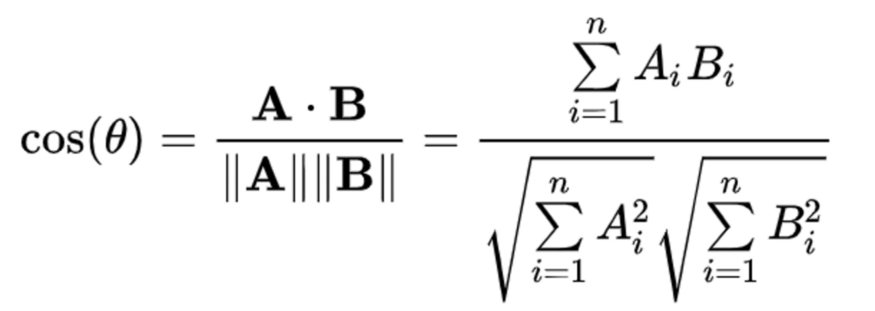

### Similarity = Cos(θ)

#### Cosine similarity is a metric, helpful in determining, how similar the data objects are irrespective of their size. We can measure the similarity between two sentences in Python using Cosine Similarity. In cosine similarity, data objects in a dataset are treated as a vector.

In [24]:
#model based on anime similarity
anime_similarity = cosine_similarity(piv_sparse)

#Df of anime similarities
ani_sim_df = pd.DataFrame(anime_similarity, index = pivot_n.index, columns = pivot_n.index)

In [25]:
def anime_recommendation(ani_name):
    number = 1
    print('Recommended because you watched {}:\n'.format(ani_name))
    for anime in ani_sim_df.sort_values(by = ani_name, ascending = False).index[1:6]:
        print(f'#{number}: {anime}, {round(ani_sim_df[anime][ani_name]*100,2)}% match')
        number +=1  

**This function will return the top 5 shows with the highest cosine similarity value and show match percent**

In [30]:
anime_recommendation('Death Note')

# Conclusion :)

In this notebook, a recommendation algorithm based on cosine similarity was created